EE 447 Project : Yeqi Chen 
===

Control of a predator-prey system

**<span style="color: darkgreen">Due Friday June 14 at 11:59pm</span>**


In [134]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from sympy import *
from control import *
from IPython.display import display, Markdown
import numpy as np
import scipy.integrate as spi
import scipy.linalg as spl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sympy import *
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from control import * 

%matplotlib inline

# Comment out in Google colab 
init_printing(use_latex='mathjax')

# Uncomment in below Google colab to render sympy equations nicely
# def custom_latex_printer(exp,**options):
#     from google.colab.output._publish import javascript
#     url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
#     javascript(url=url)
#     return printing.latex(exp,**options)
# init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)

def center(plt):
    plt.gca().spines['left'].set_position('center')
    plt.gca().spines['bottom'].set_position('center')
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    plt.gca().set_aspect('equal') 
    
def poles(plt,poles):
    center(plt)
    for p in poles:
        plt.plot([p[0]-0.1,p[0]+0.1],[p[1]-0.1,p[1]+0.1],'black')
        plt.plot([p[0]-0.1,p[0]+0.1],[p[1]+0.1,p[1]-0.1],'black')   
        plt.xlabel("Im", labelpad=100)
        plt.ylabel("Re", labelpad=140)       
def MatrixFromColumns(clist):
    return Matrix(clist).reshape(
        clist[0].shape[0], 
        len(clist)).transpose()

ModuleNotFoundError: No module named 'JSAnimation'

# Intoduction

In this project I'm going to control system consisting of a chemostat
of well-mixed nutrients and two types of microscopic organisms: algae
and rotifers.  The concentration of nutrients in the system as a function of time is
$n(t)$ micromoles per microliter. The concentrations of algae and
rotifers in the system are $a(t)$ and $b(t)$ cells per microliter
respectively. The control input is the rate $u(t)$ at which nutrients
are added to the system. The output $y(t)$ of the system is the
concentration $b(t)$ of predator cells in the system. The rotifers
have been genetically engineered to express a protein called green
fluorescent protein (GFP) (usually found in jellyfish), which
can be measured continuously with a spectrofluorimeter.

<img width=35% src="https://raw.githubusercontent.com/klavins/ECE447/master/images/chemostat.png">

A model of the dynamics of this system is as follows. Nutrients are
added to the system at a rate $u$ and are digested by algae at a rate
proportional to the concentration of nutrients times the concentration
of algae. Symbolically,

$$
\dot n = u - k_1 n a, 
$$

where $k_1 > 0$ is the rate of digestion. Algae reproduce at a rate
proportional to the rate of nutrient digestion. However, the algae are
eaten by rotifers at rate proportional to the product of their
concentrations. Also, the algae die at a certain rate as well. In
symbols,

$$
\dot a = k_1 \alpha n a - k_2 a b - k_3 a,
$$

where $\alpha > 0$, $k_2 > 0$ and $k_3 > 0$. Finally, the rotifers
reproduce at a rate proportional to the rate ate which they eat algae,
and they die because their genetic alterations make the nutrient
poisonous to them.

$$
\dot b = k_2 \beta a b - k_4 n b.
$$

Finally, as was described above, the output is

$$
y = b.
$$

Suppose the parameters have been measured and found to be
approximately

\begin{eqnarray*}
k_1 & = & 0.5 \\
k_2 & = & 0.7 \\
k_3 & = & 0.5 \\
k_4 & = & 0.9 \\
\alpha & = & 1.1 \\
\beta & = & 2.0 .
\end{eqnarray*}

Note: all rates are measured in reactions per hour. 

# Task 1: Simulation

Assume that the initial density of algae is 10, and the initial density of the rotifier is 0.5, initial nutrient value is 1 and u = 1.

In [66]:
def fdot(X,t,u):#setup the function 
    #u = 1;
    n = X[0];
    a = X[1];
    b = X[2];
    k1 = 0.5;
    k2 = 0.7;
    k3 = 0.5;
    k4 = 0.9;
    alpha = 1.1 ; 
    beta = 2.0;
    return [u - k1*n*a,k1*alpha*n*a - k2*a*b - k3*a, k2*beta* a * b - k4 * n * b]

Text(0.5, 1.0, 'system equilibrium status over time ')

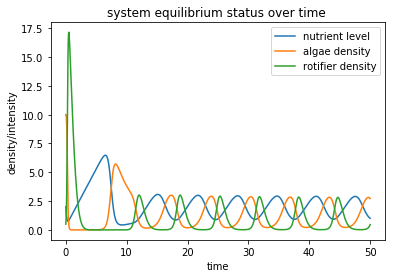

In [5]:
init = [2,10,0.5]
u = 1
t = np.linspace(0,50,1000)
df = lambda x,t: fdot(x,t,u)
f = spi.odeint(df,init,t)
plt.plot(t,f)
plt.legend(['nutrient level','algae density','rotifier density'])
plt.xlabel('time')
plt.ylabel('density/intensity')
plt.title('system equilibrium status over time ')

As we can see in the graph, the concentration of three things are periodically twist together. 

# Task 2: Performance Specification

It turns out that the algae will evolve to defend themselves against
the rotifers when the rotifer population is high. Thus, the goal is to stabilize the concentration of rotifers at 1.0 cells per microliter to prevent the rapid evolution
of the algae. The rate at which the algae evolve is on the order of 5
hours. Thus, the rotifer population should be stabilized within that
time with the minimum overshoot possible.


If it turns to mathmatical specification, it means that the percent overshoot should be ideally small, and the settling time should be less than 5 hours. 

# Task 3: Linearization

In order to better control the system, I would o the linearization. 
Setting that b = 1 as a reference point and found  $n$, $a$ and $u$ are required to keep
$b=b^*=1$. I Called these values $n^*$, $a^*$ and $u^*$. Then I used the error coordinates and the change of coordinate method to obtain the linearization around ${\bf x}_e = {\bf x} - {\bf x}^*$. Linearize the model of 
\begin{eqnarray*}
\dot {\bf x}_e & = & A {\bf x}_e + B u_e \\
y_e & = & C {\bf x}_e
\end{eqnarray*}

where $y_e$ is the difference between the desired concentration of
rotifer and the measured concentration. Also, I calculated the poles and transfer function of the system. 

The Jacobian Matrix: 
$$
\frac{\partial f}{\partial x} = \left(
\begin{array}{ccc}
  \frac{\partial f_1}{\partial n} & \frac{\partial f_1}{\partial a} & \frac{\partial f_1}{\partial b} \\
  \frac{\partial f_2}{\partial a} & \frac{\partial f_2}{\partial a} & \frac{\partial f_2}{\partial b}\\
  \frac{\partial f_3}{\partial a} & \frac{\partial f_3}{\partial a} & \frac{\partial f_3}{\partial b} 
\end{array}
\right )
$$
$$ = \left(
\begin{array}{ccc}
  \frac{\partial (u-0.5na)}{\partial n} & \frac{\partial (u-0.5na)}{\partial a} & \frac{\partial (u-0.5na)}{\partial b} \\
  \frac{\partial (0.55na-0.5ab-0.5a)}{\partial n} & \frac{\partial (0.55na-0.5ab-0.5a)}{\partial a} & \frac{\partial (0.55na-0.5ab-0.5a)}{\partial b}\\
  \frac{\partial (1.4ab-0.9bn)}{\partial n} & \frac{\partial (1.4ab-0.9bn)}{\partial a} & \frac{\partial (1.4ab-0.9bn)}{\partial b} 
\end{array}
\right )
$$

$$ = \left(
\begin{array}{ccc}
  -0.5a & -0.5n & 0 \\
  0.55a & {-0.5b-0.5} & -0.5a\\
  -0.9b & 1.4b & -0.9n  
\end{array}
\right )
$$



In [6]:
#In following cells I solved the equation for a,b and u step by step. 
var('a,b,n,u,c')
k1 = 0.5;
k2 = 0.7;
k3 = 0.5;
k4 = 0.9;
alpha = 1.1 ; 
beta = 2.0;
b = 1;
ndot = u - k1*n*a
adot = k1*alpha*n*a - k2*a*b - k3*a
bdot = k2*beta* a * b - k4 * n * b
bdot = bdot.subs(b,1)
a1 = solve(bdot,a)
a1

[0.642857142857143⋅n]

In [7]:
ndot.subs(a,a1[0])
u1 = solve(ndot,u)
u1 = u1[0].subs(a,0.642857*n)
u1

           2
0.3214285⋅n 

In [8]:
adot = adot.subs(a,a1[0]).subs(u,u1)
n1 = solve(adot, n)
n1

[0.0, 2.18181818181818]

In [9]:
u1 = u1.subs(n, n1[1])
u1

1.53010591735537

In [10]:
a1 = a1[0].subs(n,n1[1])
a1

1.40259740259740

By solving the equations with the calculation we have $$a^* \approx 1.4, u^* \approx 1.53, n^* \approx 2.18  \\ and b = 1.$$
Plug in to the Jacobian Matrix we acquired above: 
$$ = \left(
\begin{array}{ccc}
  -0.5a & -0.5n & 0 \\
  0.55a & {-0.5b-0.5} & -0.5a\\
  -0.9b & 1.4b & -0.9n  
\end{array}
\right )
$$
$$ = \left(
\begin{array}{ccc}
  -0.7 & -1.09 & 0 \\
  0.77 & -1 & -0.7\\
  -0.9 & 1.4 & -1.96 
\end{array}
\right )
$$

So near 1 the system looks like 
$$
\left(
\begin{array}{c} 
\dot a \\ 
\dot n \\
\dot b
\end{array} \right )
\approx
\left(
\begin{array}{cc}
  -0.7 & -1.09 & 0 \\
  0.77 & -1 & -0.7\\
  -0.9 & 1.4 & -1.96 
\end{array}
\right)
\left (
\begin{array}{c} 
n\\ 
a\\
b
\end{array} \right )
=
\left (
\begin{array}{c} 
{-0.7n-1.09a}\\ 
{0.77n-a-0.7b}\\
{-0.9n+1.4a-1.96b}
\end{array} \right )
$$


Then we use the change of the coordinate method: 
for the system we look the point at (n,a,b) = (2.18,1.4,1.0), so 

$$f
\left( \begin{array}{ccc} 
n_e + 1.4 \\ 
a_e + 2.18 \\
b_e + 1.0
\end{array} \right ) = 
  \left(
\begin{array}{ccc}
  {-0.5(a_e + 2.18)} &{ -0.5(n_e + 1.4)} & 0 \\
 { 0.55(a_e + 2.18)} & {-0.5(b_e + 1.0)-0.5} & {-0.5(a_e + 2.18)}\\
  {-0.9(b_e + 1.0)} & {1.4(b_e + 1.0)} & {-0.9(n_e + 1.4) } 
\end{array}
\right )
$$
so when $n_e, a_e, b_e = 0$, the system looks like: 
$$
\left (
\begin{array}{ccc}
  -1.14  &  -0.7 & 0 \\
 {1.2} & {-1.0 } & {-1.14}\\
  {-0.9} & {1.4} & {-1.26 } 
\end{array} \right )\left (
\begin{array}{c} 
n\\ 
a\\
b
\end{array} \right ) 
$$

which is the A matrix. 

So the whole system looks like: 
$$
\left (
\begin{array}{ccc}
  -1.14  &  -0.7 & 0 \\
 {1.2} & {-1.0 } & {-1.14}\\
  {-0.9} & {1.4} & {-1.26 } 
\end{array} \right )\left (
\begin{array}{c} 
n\\ 
a\\
b
\end{array} \right ) + \left( \begin{array}{c} 0\\0\\1
\end{array}\right )u_e
$$
$$
y_e = (0,0,1)x_e
$$

In [11]:
#SS to TF: 
var("s")
A = Matrix([[-1.14,-0.7,0],[1.2,-1.0,-1.14],[-0.9,1.4,-1.26]])
B = Matrix([[0],[0],[1]])
C = Matrix([[0,0,1]])
Phi = (s*eye(3)-A).inv()
T = C*Phi*B
T.simplify()
num,den = fraction(T[0])
poles = solve(den,s)
T,poles

⎛⎡         ⎛     2                  ⎞    ⎤                                    
⎜⎢     1.0⋅⎝1.2⋅s  + 2.568⋅s + 2.376⎠    ⎥                                    
⎜⎢───────────────────────────────────────⎥, [-1.46366049201758, -0.96816975399
⎜⎢     3         2                       ⎥                                    
⎝⎣1.2⋅s  + 4.08⋅s  + 7.52688⋅s + 6.038928⎦                                    

                                                                 ⎞
                                                                 ⎟
121 - 1.58142457628872⋅ⅈ, -0.96816975399121 + 1.58142457628872⋅ⅈ]⎟
                                                                 ⎟
                                                                 ⎠

For this system we have three poles , two of which is complex conjugate pairs; since all the poles are on the left plane, the natural response is stable. 

# Task 4: Root Locus Design

In this step, I figured out the root locus for the system, and I found that doesn't meet  the requirements, so I designed a compensator to implement two new pairs of the root to the system, which meets the design specification in the task 2. 

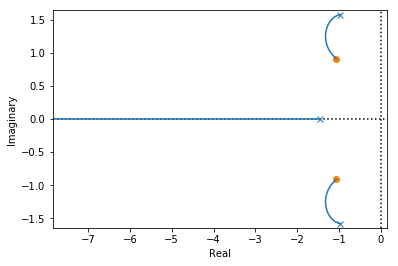

In [12]:
#a)
sys = tf([1.2,2.568,2.376],[1.2,4.08,7.52688,6.038928])
plot = root_locus(sys)

For the design specification we need to have the settling time less than 5 hours and the percent overshoot is resonablly small, say 10%.Also, since it's a reality problem, we won't risk to ruin the experiment, so let's set the settling time to be 4.5 hours. 
so we have the equation: $$\zeta\omega =4.5, \\\frac{\zeta\pi}{\beta} = -ln(0.1)$$
where $\beta = \sqrt{1-\zeta^2}$. 
As 

In [13]:
var("s,zeta,omega")#Solving the equation 
sol = solve([zeta*omega-4.5,zeta*pi/sqrt(1-zeta**2)-log(0.1)])
sol

[{ω: -7.61221632687785, ζ: -0.591155033798898}]

putting the value into the PID controller: $s^2+2\zeta\omega s + \omega^2$: 


In [14]:
deno = (s**2  + 2*zeta*omega*s + omega**2).subs(sol[0])
zeros = solve(deno,s)
deno,zeros

⎛ 2                                                                           
⎝s  + 9.0⋅s + 57.9458374071857, [-4.5 - 6.13969359228827⋅ⅈ, -4.5 + 6.139693592

        ⎞
28827⋅ⅈ]⎠

The new values of the poles is what we add using the compensator. Since the root-locus already has two pairs of pole-zeros, we can add another two pairs to meet our design specs. 

In [15]:
Gc = deno/s
G = num/den
GcG = Gc*G
Gc,GcG.cancel()
# the compensator equation, and the total equation. 

⎛ 2                                 ⎛     4           3                     2 
⎜s  + 9.0⋅s + 57.9458374071857  1.0⋅⎝1.2⋅s  + 13.368⋅s  + 95.0230048886228⋅s  
⎜─────────────────────────────, ──────────────────────────────────────────────
⎜              s                                           4         3        
⎝                                                     1.2⋅s  + 4.08⋅s  + 7.526

                                       ⎞⎞
+ 170.188910461653⋅s + 137.679309679473⎠⎟
────────────────────────────────────────⎟
    2                                   ⎟
88⋅s  + 6.038928⋅s                      ⎠

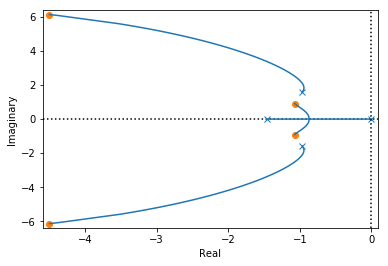

In [16]:
sysnew = tf([1.2,13.368,95.023,170.19,137.68],[1.2,4.08,7.52688,6.038928,0])
r,k = root_locus(sysnew)

As we can see, by adding the compensator, we can have two extra zeros with the desired performance and another pole at 0 to pair all the poles and zeros up.
***
Besides, if we want the root-locus to be better-looking, we can actually add another two pair of poles that is closer to two new zeros, like below: 

In [17]:
# let new poles be at -4.5 +- 6i. so the denomenator = s^2+9s+56.25. 
Gc2 = deno/(s**2+9*s+56.25)
Gc2G = Gc2*G
Gc2G.cancel()

    ⎛     4           3                     2                                 
1.0⋅⎝1.2⋅s  + 13.368⋅s  + 95.0230048886228⋅s  + 170.188910461653⋅s + 137.67930
──────────────────────────────────────────────────────────────────────────────
           5          4              3               2                        
      1.2⋅s  + 14.88⋅s  + 111.74688⋅s  + 303.280848⋅s  + 477.737352⋅s + 339.68

       ⎞
9679473⎠
────────
        
97      

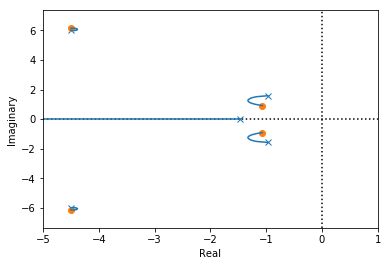

In [18]:
sysnew2 = tf([1.2,13.368,95.023,170.19,137.68],[1.2,14.88,111.74688,303.28,477.73,339.69])
r,k = root_locus(sysnew2,xlim = (-5,1))

# Task 5:  Disturbances and Noise

a)In reality, the nutrient mix may be contaminated,
resulting in its being less effective. Setting the contaminated nutrient be cn, where c represents the contamination factor that 0<c<1. I calculated the sensitivity of the output to the c. 

b) The spectrofluorimeter shines a light on the mixture and measures the
resulting fluorescence at a different wavelength. Unfortunately, this
bleaches the GFP in the system, so that the resulting output may not
be $y=b$, but $y=\gamma b$ where $0 < \gamma < 1$. I talked about the sensitivity of the output to the $\gamma$ factor. 

a. for the contamination problem, let's set a contaminate factor C, which represents the percentage of the effecctiveness of the nutrient, so 0<c<1. So let's replace n with C*n in the Differential equations and then find its Jacobian:
$$ = \left(
\begin{array}{ccc}
  -0.5ac & -0.5cn & 0 \\
  0.55ac & {-0.5b-0.5} & -0.5a\\
  -0.9bc & 1.4b & -0.9cn  
\end{array}
\right )
$$
Plug in the value of calculation and the Change of coordinate method in procedure 1: 

In [19]:
ndotc = u - k1*c*n*a
adotc = k1*alpha*c*n*a - k2*a*b - k3*a
bdotc = k2*beta* a * b - k4 * c*n * b
bdotc = bdotc.subs(b,1)
a1 = solve(bdotc,a)
ndot.subs(a,a1[0])
u1 = solve(ndotc,u)
u1 = u1[0].subs(a,0.642857*n)
adotc = adotc.subs(a,a1[0]).subs(u,u1)
n1 = solve(adotc, n)
u1 = u1.subs(n, n1[1])
a1 = a1[0].subs(n,n1[1])
a1,n1[1],u1
# solved the equations in task 1 again, taht regard C as an parameter. 

⎛                 2.18181818181818  1.53010591735537⎞
⎜1.4025974025974, ────────────────, ────────────────⎟
⎝                        c                 c        ⎠

Plug in the values above: 
$$
\left (
\begin{array}{ccc}
  -1.14c  &  -0.7 & 0 \\
 {1.2c} & {-1.0 } & {-1.14}\\
  {-0.9c} & {1.4} & {-1.26 } 
\end{array} \right )\left (
\begin{array}{c} 
n\\ 
a\\
b
\end{array} \right ) 
$$

In [67]:
#SS to TF
var("s,c")
Ac = Matrix([[-1.14*c,-0.7,0],[1.2*c,-1.0,-1.14],[-0.9*c,1.4,-1.26]])
Bc = Matrix([[0],[0],[1]])
Cc = Matrix([[0,0,1]])
Phi = (s*eye(3)-Ac).inv()
T = Cc*Phi*Bc
#num,den = fraction(T[0])
#poles = solve(den,s)
T

⎡                           (0.84⋅c + (1.14⋅c + s)⋅(s + 1.0))⋅(1.14⋅c + s)    
⎢─────────────────────────────────────────────────────────────────────────────
⎣-(-2.226⋅c - 1.4⋅s)⋅(1.2996⋅c + 1.14⋅s) + (0.84⋅c + (1.14⋅c + s)⋅(s + 1.0))⋅(

                      ⎤
──────────────────────⎥
1.14⋅c + s)⋅(s + 1.26)⎦

In [68]:
Sensitivityc = T.diff(c)*c/T
Sensitivityc

⎡                                                                             
⎢c⋅(-(-2.226⋅c - 1.4⋅s)⋅(1.2996⋅c + 1.14⋅s) + (0.84⋅c + (1.14⋅c + s)⋅(s + 1.0)
⎢                                                                             
⎢                                                                             
⎢─────────────────────────────────────────────────────────────────────────────
⎣                                                                             

                           ⎛(0.84⋅c + (1.14⋅c + s)⋅(s + 1.0))⋅(1.14⋅c + s)⋅(-5
)⋅(1.14⋅c + s)⋅(s + 1.26))⋅⎜──────────────────────────────────────────────────
                           ⎜                                                  
                           ⎝                                 (-(-2.226⋅c - 1.4
──────────────────────────────────────────────────────────────────────────────
                                                                              

.7858192⋅c - 4.35708⋅s - 1.14⋅(0.84⋅c + (1.14⋅c + 

The sensitivity of the system is hard to tell based on the observation. 

#b) Assume it asks the sensitivity of the output of the system to $\gamma$. 
so $S^T_\gamma = \frac{\partial T}{\partial\gamma} * \frac{\gamma}{T}$ 
$$ = \frac{\partial \gamma b }{\partial \gamma}\frac{\gamma}{\gamma b} \\ 
    = 1$$. 
 So the sensitivity of the system is a constant 1. Actually since it's only a multiplication factor of the output, the output is always porpotional to the $\gamma$. 

# Task 6: Full State Feedback
Assume we keep using the model from the linearization. So let's calculate the controllability of the system. 

In [69]:
M = MatrixFromColumns([B,A*B,A*A*B])
M,M.rank()

⎛⎡0    0           0.798        ⎤   ⎞
⎜⎢                              ⎥   ⎟
⎜⎢0  -1.14         2.5764       ⎥, 3⎟
⎜⎢                              ⎥   ⎟
⎝⎣1  -1.26  -0.00839999999999974⎦   ⎠

Since it has the full rank, the system is controllable. 
So let's work on the Performance Specification: Settling time 4.5Hour, and 10% overshoot. 
For a rank 3 matrix, we will have 3 poles, so I choose to put another pole at -1.

In [23]:
zeros

[-4.5 - 6.13969359228827⋅ⅈ, -4.5 + 6.13969359228827⋅ⅈ]

In [24]:
var("s")
desired_charpoly = ((s+4.5+6.14*I)*(s+4.5-6.14*I)*(s+1)).expand()
desired_charpoly

 3         2                      
s  + 10.0⋅s  + 66.9496⋅s + 57.9496

In [25]:
var("k0 k1 k2")
K = Matrix([[k0,k1,k2]])
charpoly = (s*eye(3)-(A-B*K)).det()
charpoly

0.798⋅k₀ + 0.84⋅k₂ + 0.84⋅s - (k₁ - 1.4)⋅(1.14⋅s + 1.2996) + (s + 1.0)⋅(s + 1.
14)⋅(k₂ + s + 1.26) + 1.7766

In [26]:
c1 = Poly(desired_charpoly,s).coeffs()
c2 = Poly(charpoly,s).coeffs()
Matrix(c1), Matrix(c2)

⎛⎡  1.0  ⎤  ⎡                  1.0                   ⎤⎞
⎜⎢       ⎥  ⎢                                        ⎥⎟
⎜⎢ 10.0  ⎥  ⎢              1.0⋅k₂ + 3.4              ⎥⎟
⎜⎢       ⎥, ⎢                                        ⎥⎟
⎜⎢66.9496⎥  ⎢      -1.14⋅k₁ + 2.14⋅k₂ + 6.2724       ⎥⎟
⎜⎢       ⎥  ⎢                                        ⎥⎟
⎝⎣57.9496⎦  ⎣0.798⋅k₀ - 1.2996⋅k₁ + 1.98⋅k₂ + 5.03244⎦⎠

In [27]:
gains = solve(Matrix(c1)-Matrix(c2),[k0,k1,k2])
Ksol = K.subs(gains)
Ksol

[-16.5682807017544  -40.8361403508772  6.6]

so that a choice of $k_0 = -16.57$ , $k_1 = -40.84$ and $k_2 = 6.6$ will put the closed loop poles at the desired locations.

Impulse response: 

In [28]:
#Transfer function polynomial
charpoly = charpoly.subs(k2,6.6).subs(k1,-40.836).subs(k0,-16.568)
charpoly.simplify()

 3         2                          
s  + 10.0⋅s  + 66.94944⋅s + 57.9496416

A-BK =
\begin{align}
A-BK & = \begin{pmatrix}
-0.7 & -1.09 & 0  \\
0.77 & -1  &-0.7\\
-0.9 & -1   & -1.96
\end{pmatrix} - \begin{pmatrix}
0 \\
0 \\
1
\end{pmatrix} (6.6 \;-40.84\;-16.57 ) \\
 & = \begin{pmatrix}
-0.7 & -1.09 & 0  \\
0.77 & -1  &-0.7\\
-7.5 & 42.24  &14.61
\end{pmatrix} 
\end{align}

In [70]:
var("a0 a1 b0 b1 s")
ABK = Matrix([
    [-0.7,-1.09,0],
    [0.77,-1,-0.7],
    [-7.5,42.24,14.61]
])
B = Matrix([[0],[0],[1]])
C = Matrix([[0,0 , 1]])
Tfs = (C*(s*eye(3)-A).inv()*B)[0]
Tfs = cancel(Tfs)
Tfs


         ⎛     2                  ⎞    
     1.0⋅⎝1.2⋅s  + 2.568⋅s + 2.376⎠    
───────────────────────────────────────
     3         2                       
1.2⋅s  + 4.08⋅s  + 7.52688⋅s + 6.038928

Text(0, 0.5, 'density')

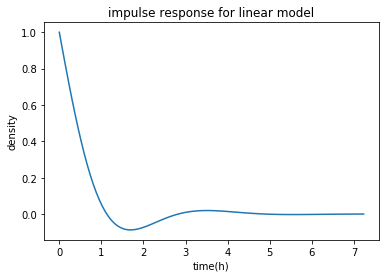

In [89]:
#Since it has bug when ILT the float  numbers, I rounded the numbers nearest ones.
numt,dent = fraction(Tfs)
T, ffs = impulse_response( TransferFunction([1.2,2.568,2.376],[1.2,4.08,7.527,6.039]))
plt.plot(T,ffs)
plt.title('impulse response for linear model')
plt.xlabel('time(h)')
plt.ylabel('density')

# Task 7: Observer Design

a) Unfortunately, it is not easy to measure the population of algae or
the concentration of nutrients. Determine whether the system is observable. If it is,
design an observer for the system. Explain your choice of observer gains.

b) Build a simulation of the system using your full state
controller and the observer. Plot the impulse response using the
linear and the nonlinear model. Assume that the concentration of
nutrients is initially $n(0)=0$. Plot the estimates of the other
states as well.

In [42]:
O = Matrix([C,C*A,C*A**2])
O, O.rank()

⎛⎡ 0      0              1          ⎤   ⎞
⎜⎢                                  ⎥   ⎟
⎜⎢-0.9   1.4           -1.26        ⎥, 3⎟
⎜⎢                                  ⎥   ⎟
⎝⎣3.84  -2.534  -0.00839999999999974⎦   ⎠

Since O has full rank, the system is observable. 

In [46]:
Approx = Matrix([[-1,-0.7,0],[1,-1,-1],[-1,1.5,1.3]])

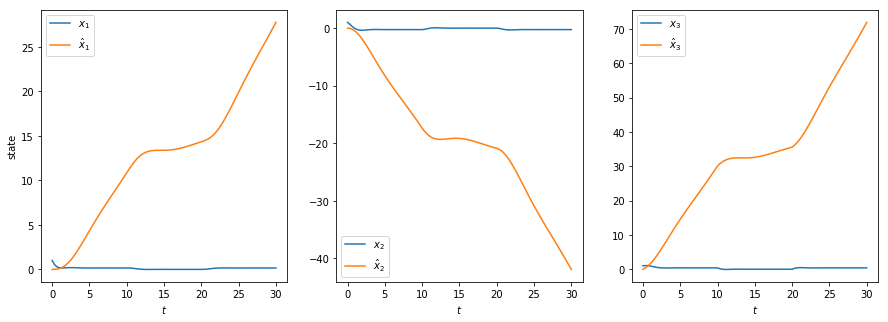

In [169]:
def input(t):
    if t < 10:
        return 1
    elif t < 20:
        return 0
    else:
        return 1 
def f(X,t):
    x = Matrix([X[:3]]).transpose()
    xhat = Matrix([X[3:6]]).transpose()
    u = input(t)
    fb = L * ( C*x - C*xhat )
    return flatten(
        (A*x + B*u).tolist() + 
        (Approx*Matrix(xhat) + B*u).tolist())
t=np.linspace(0,30,100)
X = spi.odeint(f,[1,1,1,0,0,0],t)
fig,ax = plt.subplots(1,3,figsize=(15,5))

for i in range(3):
    ax[i].plot(t,X[:,i],label="$x_%d$" % (i+1))
    ax[i].plot(t,X[:,3+i],label="$\hat{x}_%d$" % (i+1));
    ax[i].set_xlabel("$t$")
    ax[i].legend()
    
ax[0].set_ylabel("state");

To put the poles at the place we designated, at -1, -4.5$\pm$ 6.14i, we can find out the gain matrix L using A-LC. 

In [175]:
An = np.array(Approx.transpose()).astype(np.float64)
Cn = np.array(C.transpose()).astype(np.float64)

desired_poles = 4*np.linalg.eig(An)[0]
desired_poles = np.array([ -1, -4.5, 4.5])
L = Matrix(place(An,Cn,desired_poles)).transpose()
L

⎡5.44576271186441 ⎤
⎢                 ⎥
⎢-10.6694915254237⎥
⎢                 ⎥
⎣       0.3       ⎦

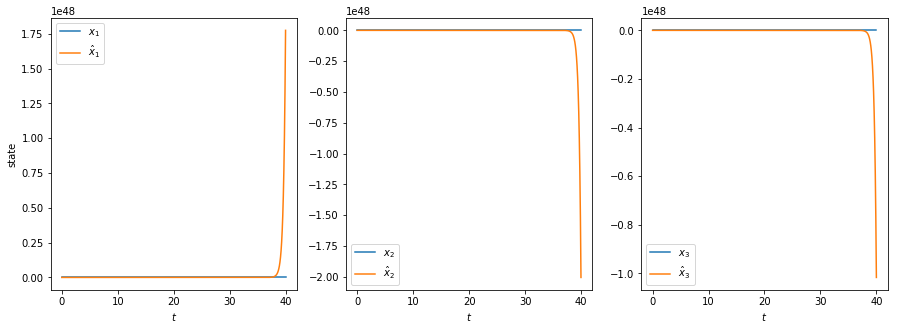

In [176]:
def input(t):
    if t < 10:
        return 1
    elif t < 20:
        return 0
    else:
        return 1 
def f(X,t):
    x = Matrix([X[:3]]).transpose()
    xhat = Matrix([X[3:6]]).transpose()
    u = input(t)
    fb = L * ( C*x - C*xhat )
    return flatten(
        (A*x + B*u).tolist() + 
        (A*xhat + B*u + fb).tolist())

t=np.linspace(0,40,400)
X = spi.odeint(f,[3,2,1,0,0,0],t)
fig,ax = plt.subplots(1,3,figsize=(15,5))

for i in range(3):
    ax[i].plot(t,X[:,i],label="$x_%d$" % (i+1))
    ax[i].plot(t,X[:,3+i],label="$\hat{x}_%d$" % (i+1));
    ax[i].set_xlabel("$t$")
    ax[i].legend()
    
ax[0].set_ylabel("state");

As we can see, this is actually a bad design for the observer. 

# Task 8: Discretization

Derive a discrete model of one of your controlled systems (either the root locus version, the full state feedback version, or the full state feedback with observer version).  Plot the magnitude of the eigenvalues of the closed loop system versus the sampling period. Determine maximum sampling period you can use with your controller that keeps the system stable.

In [163]:
In this task I derived the discrete model for the controlled system in the full state feedback version. 

SyntaxError: invalid syntax (<ipython-input-163-8280e9e67808>, line 1)

In [160]:
def trajectory(A,B,C,u,x0):
    """Simulate the discrete system x(k+1) = Ax(k) + Bu(k), y(k) = Cx(k)
       starting at x0 for len(u) steps.
    """
    i = 0
    x = x0    
    y = [np.matmul(C,x0)]
    while i < len(u):
        x = np.matmul(A,x) + B*u[i]
        y = np.append(y,np.matmul(C,x))
        i = i + 1


In [161]:
A,B,C

(array([[-1.14, -0.7 ,  0.  ],
        [ 1.2 , -1.  , -1.14],
        [-0.9 ,  1.4 , -1.26]]), array([[0],
        [0],
        [1]]), array([[0, 0, 1]]))

ValueError: x, y, and format string must not be None

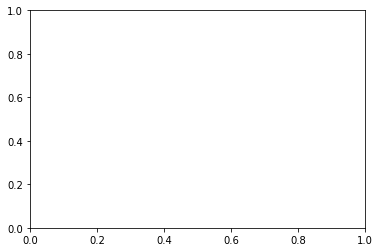

In [162]:
A = np.array([
    [-1.14,-0.7,0],
    [1.2,-1.0,-1.14],
    [-0.9,1.4,-1.26]
])
B = np.array([
    [0],
    [0],[1]
])
C = np.array([[0,0,1]])
x0 = np.array([
    [0],
    [0],
    [0]
])
u = np.ones(30);
t = np.linspace(0,30,31)
ysim = trajectory(A,B,C,u,x0)
plt.step(t,ysim)
plt.xlabel("k")
plt.ylabel("y(k)")
plt.title("Simulation of a discrete system");

I don't know where the problem is. 

In [144]:
def solution(A,B,C,u,x0):
    k = len(u)
    if k == 0:
        return np.matmul(C,x0)[0]
    else:
        x = np.matmul(np.linalg
                      .matrix_power(A,k),x0) + sum([
              np.matmul(np.linalg.matrix_power(A,k-i-1),B)*u[i] for i in range(k)
            ])
        return np.matmul(C,x)[0,0]

def step_response(A,B,C,n,mag=1):
    # Note, this is a pretty innefficient way to compute a response. The
    # simulation above is just as accurate, but much faster.
    t = np.linspace(0,n,n+1)
    x0 = np.zeros(len(B))
    y = np.array([solution(A,B,C,mag*np.ones(k),x0) for k in range(n+1)])
    return (t,y)

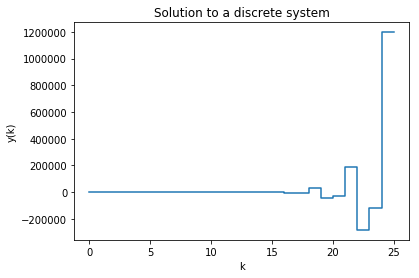

In [159]:
t,y = step_response(A,B,C,25)
plt.step(t,y)
plt.xlabel("k")
plt.ylabel("y(k)")
plt.title("Solution to a discrete system");

## Conclusion: In this project I went through the knowlege point for the quarter. although there were many imperfection and errors, I've tried to debug it for days. The class material is fun and these would be useful in the future. 